# Model Comparison Lab

In this lab we will compare the performance of all the models we have learned about so far, using the Titanic dataset.


## 1. Prepare the data

The [titanic dataset](https://www.kaggle.com/c/titanic/data) is one we've talked about a lot. Load in the train data from the assets folder.

1. Load the data into a pandas dataframe
- Encode the categorical features properly
- Separate features from target into X and y

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('assets/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Useful preparation

Since we will compare several models, let's write a couple of helper functions.

1. Separate X and y between a train and test set, using 30% test set, random state = 42
    - make sure that the data is shuffled and stratified
2. Define a function called `evaluate_model`, that trains the model on the train set, tests it on the test, calculates the evaluative measures below.
  - accuracy score
  - confusion matrix
  - classification report
3. Initialize a global dictionary to store the various models for later retrieval (your dictionary will likely contain the estimator and best score)

In [11]:
#turn sex into a dummy variable with list comprehension 
df['Sex'] = [1 if x == 'female' else 0 for x in df.Sex]

In [15]:
#drop nans 
df.dropna(inplace=True)

In [16]:
#declaring my X to be Pclass, Fare, Sex, and Age (Will come back and add the other features later)
X = df[['Pclass', 'Sex', 'Age', 'Fare']]
y = df.Survived

In [17]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def evaluate_model(model,name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print cm
    print cr
    
    return a

all_models = []

## 3.a KNN

Let's start with `KNeighborsClassifier`.

1. Initialize a KNN model
- Evaluate its performance with the function you previously defined
- Find the optimal value of parameter K using grid search
    - Be careful on how you perform the cross validation in the grid search

In [18]:
from sklearn.neighbors import KNeighborsClassifier

a = evaluate_model(KNeighborsClassifier())

[[ 3 15]
 [ 3 34]]
             precision    recall  f1-score   support

          0       0.50      0.17      0.25        18
          1       0.69      0.92      0.79        37

avg / total       0.63      0.67      0.61        55



In [22]:
from sklearn.grid_search import GridSearchCV

params = {'n_neighbors': range(2,60)}

gsknn = GridSearchCV(KNeighborsClassifier(),
                     params, n_jobs=-1,
                     cv=5)

In [23]:
gsknn.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [24]:
gsknn.best_params_

{'n_neighbors': 23}

In [25]:
gsknn.best_score_

0.6830601092896175

In [26]:
evaluate_model(gsknn.best_estimator_)

[[ 3 15]
 [ 5 32]]
             precision    recall  f1-score   support

          0       0.38      0.17      0.23        18
          1       0.68      0.86      0.76        37

avg / total       0.58      0.64      0.59        55



0.63636363636363635

## 3.b Bagging + KNN

Now that we have found the optimal K, let's wrap `KNeighborsClassifier` in a BaggingClassifier and see if the score improves.

1. Wrap the KNN model in a Bagging Classifier
- Evaluate performance
- Do a grid search only on the bagging classifier parameters

In [27]:
from sklearn.ensemble import BaggingClassifier
baggingknn = BaggingClassifier(KNeighborsClassifier())


In [28]:
evaluate_model(baggingknn)

[[ 5 13]
 [ 4 33]]
             precision    recall  f1-score   support

          0       0.56      0.28      0.37        18
          1       0.72      0.89      0.80        37

avg / total       0.66      0.69      0.66        55



0.69090909090909092

In [30]:
bagging_params = {'n_estimators': [10, 20],
                  'max_samples': [0.7, 1.0],
                  'max_features': [0.7, 1.0],
                  'bootstrap_features': [True, False]}


gsbaggingknn = GridSearchCV(baggingknn,
                            bagging_params, n_jobs=-1,
                            cv=5)

In [31]:
gsbaggingknn.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20], 'max_samples': [0.7, 1.0], 'bootstrap_features': [True, False], 'max_features': [0.7, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [32]:
gsbaggingknn.best_params_

{'bootstrap_features': True,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 20}

In [33]:
all_models['gsbaggingknn'] = {'model': gsbaggingknn.best_estimator_,
                              'score': evaluate_model(gsbaggingknn.best_estimator_)}

[[ 5 13]
 [ 2 35]]
             precision    recall  f1-score   support

          0       0.71      0.28      0.40        18
          1       0.73      0.95      0.82        37

avg / total       0.72      0.73      0.68        55



## 4. Logistic Regression

Let's see if logistic regression performs better.

1. Initialize LR and test on Train/Test set
- Find optimal parameters with Grid Search
- See if Bagging improves the score

In [34]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
all_models['lr'] = {'model': lr,
                    'score': evaluate_model(lr)}

[[14  4]
 [ 9 28]]
             precision    recall  f1-score   support

          0       0.61      0.78      0.68        18
          1       0.88      0.76      0.81        37

avg / total       0.79      0.76      0.77        55



In [36]:
params = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
          'penalty': ['l1', 'l2']}

gslr = GridSearchCV(lr,
                    params, n_jobs=-1,
                    cv=5)

gslr.fit(X, y)

print gslr.best_params_
print gslr.best_score_

all_models['gslr'] = {'model': gslr.best_estimator_,
                             'score': evaluate_model(gslr.best_estimator_)}

{'penalty': 'l1', 'C': 1.0}
0.775956284153
[[15  3]
 [10 27]]
             precision    recall  f1-score   support

          0       0.60      0.83      0.70        18
          1       0.90      0.73      0.81        37

avg / total       0.80      0.76      0.77        55



In [38]:
gsbagginglr = GridSearchCV(BaggingClassifier(gslr.best_estimator_),
                           bagging_params, n_jobs=-1,
                           cv=5)

gsbagginglr.fit(X, y)

print gsbagginglr.best_params_
print gsbagginglr.best_score_

all_models['gsbagginglr'] = {'model': gsbagginglr.best_estimator_,
                             'score': evaluate_model(gsbagginglr.best_estimator_)}

{'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 20, 'bootstrap_features': True}
0.770491803279
[[12  6]
 [ 7 30]]
             precision    recall  f1-score   support

          0       0.63      0.67      0.65        18
          1       0.83      0.81      0.82        37

avg / total       0.77      0.76      0.77        55



## 5. Decision Trees

Let's see if Decision Trees perform better.

1. Initialize DT and test on Train/Test set
- Find optimal parameters with Grid Search
- See if Bagging improves the score

In [39]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
all_models['dt'] = {'model': dt,
                    'score': evaluate_model(dt)}

[[13  5]
 [ 6 31]]
             precision    recall  f1-score   support

          0       0.68      0.72      0.70        18
          1       0.86      0.84      0.85        37

avg / total       0.80      0.80      0.80        55



In [41]:
params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gsdt = GridSearchCV(dt,
                    params, n_jobs=-1,
                    cv=5)

gsdt.fit(X, y)
print gsdt.best_params_
print gsdt.best_score_

all_models['gsdt'] = {'model': gsdt.best_estimator_,
                      'score': evaluate_model(gsdt.best_estimator_)}

{'min_samples_split': 2, 'splitter': 'random', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3}
0.79781420765
[[17  1]
 [15 22]]
             precision    recall  f1-score   support

          0       0.53      0.94      0.68        18
          1       0.96      0.59      0.73        37

avg / total       0.82      0.71      0.72        55



In [43]:
gsbaggingdt = GridSearchCV(BaggingClassifier(gsdt.best_estimator_),
                           bagging_params, n_jobs=-1,
                           cv=5)

gsbaggingdt.fit(X, y)

print gsbaggingdt.best_params_
print gsbaggingdt.best_score_

all_models['gsbaggingdt'] = {'model': gsbaggingdt.best_estimator_,
                             'score': evaluate_model(gsbaggingdt.best_estimator_)}

{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'bootstrap_features': True}
0.75956284153
[[10  8]
 [ 6 31]]
             precision    recall  f1-score   support

          0       0.62      0.56      0.59        18
          1       0.79      0.84      0.82        37

avg / total       0.74      0.75      0.74        55



## 6. Random Forest & Extra Trees

Let's see if Random Forest and Extra Trees perform better.

1. Initialize RF and ET and test on Train/Test set
- Find optimal parameters with Grid Search


In [44]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier()
all_models['rf'] = {'model': rf,
                    'score': evaluate_model(rf)}



et = ExtraTreesClassifier()
all_models['et'] = {'model': et,
                    'score': evaluate_model(et)}


[[11  7]
 [ 5 32]]
             precision    recall  f1-score   support

          0       0.69      0.61      0.65        18
          1       0.82      0.86      0.84        37

avg / total       0.78      0.78      0.78        55

[[13  5]
 [ 6 31]]
             precision    recall  f1-score   support

          0       0.68      0.72      0.70        18
          1       0.86      0.84      0.85        37

avg / total       0.80      0.80      0.80        55



In [46]:
params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=5)

gsrf.fit(X, y)
print gsrf.best_params_
print gsrf.best_score_

all_models['gsrf'] = {'model': gsrf.best_estimator_,
                      'score': evaluate_model(gsrf.best_estimator_)}

{'min_samples_split': 2, 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 5, 'class_weight': 'balanced'}
0.79781420765
[[15  3]
 [13 24]]
             precision    recall  f1-score   support

          0       0.54      0.83      0.65        18
          1       0.89      0.65      0.75        37

avg / total       0.77      0.71      0.72        55



In [48]:
gset = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=5)

gset.fit(X, y)
print gset.best_params_
print gset.best_score_

all_models['gset'] = {'model': gset.best_estimator_,
                      'score': evaluate_model(gset.best_estimator_)}

{'min_samples_split': 5, 'n_estimators': 5, 'criterion': 'entropy', 'max_depth': None, 'class_weight': 'balanced'}
0.792349726776
[[14  4]
 [ 6 31]]
             precision    recall  f1-score   support

          0       0.70      0.78      0.74        18
          1       0.89      0.84      0.86        37

avg / total       0.82      0.82      0.82        55



## 8. Model comparison

Let's compare the scores of the various models.

1. Do a bar chart of the scores of the best models. Who's the winner on the train/test split?
- Re-test all the models using a 3 fold stratified shuffled cross validation
- Do a bar chart with errorbars of the cross validation average scores. is the winner the same?


,score
model,
gset,0.818182
et,0.800000
dt,0.800000
rf,0.781818
gsbagginglr,0.763636
gslr,0.763636
lr,0.763636
gsbaggingdt,0.745455
gsbaggingknn,0.727273


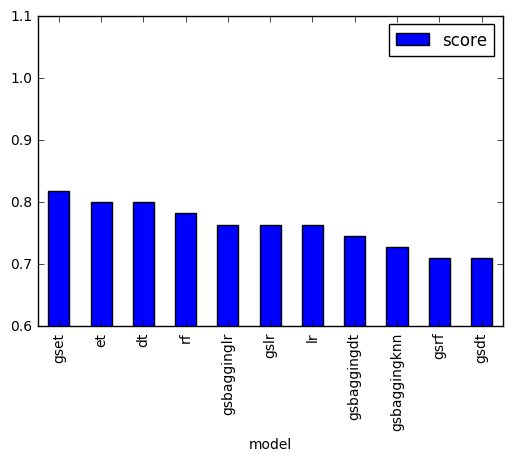

In [49]:
scores = pd.DataFrame([(k, v['score']) for k, v in all_models.iteritems()],
             columns=['model', 'score']).set_index('model').sort_values('score', ascending=False)


scores.plot(kind='bar')
plt.ylim(0.6, 1.1)

scores

In [50]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold

def retest(model):
    scores = cross_val_score(model, X, y,
                             cv=StratifiedKFold(y, shuffle=True),
                             n_jobs=-1)
    m = scores.mean()
    s = scores.std()
    
    return m, s

for k, v in all_models.iteritems():
    cvres = retest(v['model'])
    print k, 
    all_models[k]['cvres'] = cvres
    

gsbagginglr gsrf gslr rf gsbaggingdt gsdt lr gset et gsbaggingknn dt


,score,error
model,,
lr,0.775956,0.020446
gslr,0.770492,0.013385
gset,0.748634,0.007728
gsrf,0.743169,0.007728
dt,0.743169,0.033685
gsbaggingdt,0.737705,0.026770
et,0.737705,0.035414
rf,0.732240,0.038640
gsdt,0.726776,0.033685


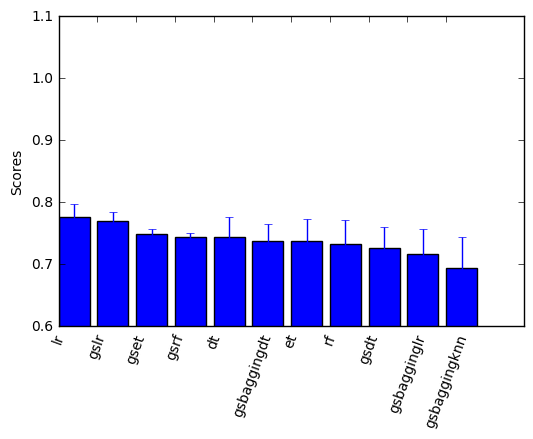

In [51]:
cvscores = pd.DataFrame([(k, v['cvres'][0], v['cvres'][1] ) for k, v in all_models.iteritems()],
                        columns=['model', 'score', 'error']).set_index('model').sort_values('score', ascending=False)



fig, ax = plt.subplots()
rects1 = ax.bar(range(len(cvscores)), cvscores.score,
                yerr=cvscores.error,
                tick_label=cvscores.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=70)
plt.ylim(0.6, 1.1)

cvscores

## Bonus

We have encoded the data using a map that preserves the scale.
Would our results have changed if we had encoded the categorical data using `pd.get_dummies` or `OneHotEncoder`  to encode them as binary variables instead?

1. Repeat the analysis for this scenario. Is it better?
- Experiment with other models or other parameters, can you beat your classmates' best score?